In [1]:
import json, numpy as np, pandas as pd, time
from collections import defaultdict, OrderedDict
from copy import deepcopy
import datetime
from pandas import *
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
task_name = "诚信数据"
check_start_date = '2019'  # eg: 2018.06 -> now  check_end_date

In [3]:
# 状态管理
demand_states = {'任务已分发', '驳回运维意见', '待处理'}
developer_states = {'初爬通过', '正在开发', '自查完成', '正在下载源码', '正在修改', '代码完成',
                    '解析完成', '请求撤回提交', '开发完成', '源码下载完成', '疑难网站',
                    '提交任务', '初爬完成', '研发修改完成', '驳回测试修改意见', '正在解析'}
cleaning_states = {'文件清洗完成', '正在清洗', '清洗修改完成'}
test_states = {'测试查完成', '测试挂起', '正在测试', '初测通过', '返回清洗修改', '返回修改', '请清洗文件', '请重新下源码', '源码有问题'}
storage_states = {'返回修改', '入库复核通过', '入库失败', '入库完成', '正在入库', '不入库', '数据已转移', '暂不入库', '重跑一遍', '重跑完成'}
operations_states = {'网站异常', '停止维护', '全网查完成', '无增量挂起', '废弃需求', '运维发现异常', '驳回需求', '返回修改'}
# 特殊
abandoned_states = {'停止维护', '废弃需求'}
complete_states = {'入库完成', '数据已转移', '入库复核通过'}
event_state = ['需求', '开发', '测试', '清洗', '入库', '运维']

In [4]:
if '.' in check_start_date and check_start_date.count('.') < 2:
    check_start_year, check_start_month = [int(date) for date in check_start_date.split('.')]
else:
    check_start_year = int(check_start_date)
    check_start_month = 1
try:
    if check_end_date:
        if '.' in check_end_date and check_end_date.count('.') < 2:
            check_end_year, check_end_month = [int(date) for date in check_end_date.split('.')]
        else:
            check_end_year = int(check_start_date)
            check_end_month = 1
        check_end_date_flag = 1
    else:
        check_end_date_flag = 0
except:
    check_end_date_flag = 0
def get_data(name):
    with open('%s.json' % name, 'r', encoding='utf-8') as json_file:
        return json.loads(json_file.read())[name]
def get_spider_tasks(data_list, dupefilter=()):
    spider_tasks = defaultdict(list)
    for data in data_list:
        if data['spiderName'] in dupefilter:
            continue
        spider_tasks[data['spiderName']].append(data)
    return spider_tasks
task_data = get_data(task_name)
fina = task_data  # todo 所有数据[{}, {}]
stat = {task_name: len(task_data)}  # todo {'诚信数据': 25024}
spider_tasks = get_spider_tasks(fina)  # {'spiderName': [spiderTask1, spiderTask2]}
spider_tasks_statistics = {task_name: len(spider_tasks)}  # {'taskName': num}

In [5]:
event_name_value = dict()
operation_tasks = dict()
abandoned_tasks = dict()
storage_tasks = dict()
abandoned_tasks_2 = dict()
abandoned_tasks_3 = dict()
for spiderName, spider_task in spider_tasks.items():
    _event = [0 for _ in range(len(event_state))]
    if spider_task[-1]['rwzt'] in abandoned_states:  # 最后一个任务状态处于废弃，则认为是废弃爬虫
        abandoned_tasks.setdefault(spiderName, spider_task)
    for task in spider_task:
        if spiderName not in operation_tasks and task['rwzt'] in operations_states:  # 该爬虫有过运维经历
            operation_tasks.setdefault(spiderName, spider_task)
        if spiderName not in storage_tasks and task['rwzt'] in complete_states:  # 该爬虫有过入库经历
            storage_tasks.setdefault(spiderName, spider_task)
        for index, state in enumerate(
                [demand_states, developer_states, cleaning_states, test_states, storage_states, operations_states]):  # 统计各个经历的次数
            if task['rwzt'] in state:
                _event[index] = _event[index] + 1
                break
    event_name_value.setdefault(spiderName, _event)
for spiderName, spider_task in storage_tasks.items():
    for task in spider_task:
        if spiderName not in abandoned_tasks_2 and task['rwzt'] in operations_states:
            abandoned_tasks_2.setdefault(spiderName, spider_task)
        if spiderName not in abandoned_tasks_3 and task['rwzt'] in abandoned_states:
            abandoned_tasks_3.setdefault(spiderName, spider_task)
# print(operation_tasks)
operation_tasks_statistics = {task_name: len(operation_tasks)}  # todo {'诚信数据': 644}  经历过运维的任务
abandoned_tasks_statistics = {task_name: len(abandoned_tasks)}  # todo {'诚信数据': 326}  处于废弃状态的任务
storage_tasks_statistics = {task_name: len(storage_tasks)}  # todo {'诚信数据': 716}  历史入库完成的爬虫
storage_tasks_2_statistics = {task_name: len(abandoned_tasks_2)}  # todo {'诚信数据': 546}  历史入库完成的爬虫中, 76%左右的任务会经历运维
storage_tasks_3_statistics = {task_name: len(abandoned_tasks_3)}  # todo {'诚信数据': 252}  历史入库完成的爬虫中，35%左右的任务会被废弃

In [6]:
def get_time_format(timestamp):
    time_format_1 = '%d年%d月'
    time_format_2 = '%d年%d月%d日'
    current_time = datetime.datetime.fromtimestamp(timestamp)
    return time_format_1 % (current_time.year, current_time.month), time_format_2 % (current_time.year, current_time.month, current_time.day)
def sorted_tasks(tasks: list, key=lambda task: task['time']) -> list:
    return sorted(tasks, key=key)
def get_month_statistics(tasks):
    statistics = dict()
    for spiderName, spider_task in tasks.items():
        normal_info = OrderedDict()
        detail_info = OrderedDict()
        start = None
        for task in sorted_tasks(spider_tasks[spiderName]):
            if not start and task['rwzt'] in complete_states:
                start = task['time']
                _time = get_time_format(task['time'])
                normal_info[_time[0]] = 0
                detail_info[_time[1]] = 0
                continue
            if start and task['rwzt'] in operations_states:
                _time = get_time_format(task['time'])
                normal_info[_time[0]] = 1
                detail_info[_time[1]] = 1
        statistics[spiderName] = [normal_info, detail_info]
    return statistics
def get_life_statistics(tasks):
    life_time = {}
    for spiderName, spider_task in tasks.items():  # 遍历每一个爬虫
        start_time = None  #
        first = None  #
        last = None  #
        total_times = 0  # 这个应该是用时间算出来的
        abnormal_times = None  #
        life_time_statistics = dict()
        for task in spider_task:  # 遍历所有的任务。
            if first and task['rwzt'] in operations_states:
                life_time_statistics.setdefault('last_time', task['time'])
                life_time_statistics['abnormal_times'] = life_time_statistics.get('abnormal_times', 0) + 1
                continue
            if start_time and task['rwzt'] in operations_states:
                first = True
                life_time_statistics.setdefault('first_time', task['time'])
                life_time_statistics.setdefault('last_time', task['time'])
                life_time_statistics['abnormal_times'] = life_time_statistics.get('abnormal_times', 0) + 1
            if task['rwzt'] in complete_states:
                start_time = True
                life_time_statistics.setdefault('start_time', task['time'])  # 记录第一次的时间
        if not life_time_statistics.get('first_time'):
            continue
        if spiderName in abandoned_tasks_3:
            life_time_statistics['total_times'] = ((life_time_statistics['last_time'] - life_time_statistics['start_time']) // 2592000) or 1
            life_time_statistics['is_live'] = False
        else:
            life_time_statistics['total_times'] = ((time.time() - life_time_statistics['start_time']) // 2592000) or 1
            life_time_statistics['is_live'] = True
        if life_time_statistics['total_times'] >= life_time_statistics['abnormal_times']:
            life_time.setdefault(spiderName, life_time_statistics)
    return life_time
def get_abandoned_spider_statistics(tasks):
    abandoned_tasks = dict()
    for spiderName, spider_task in tasks.items():
        abandoned_tasks.setdefault(spiderName, sorted(spider_task, key=lambda task: task['time'])[-1]['time'])
    abandoned_tasks = sorted(abandoned_tasks.values(), key=lambda x: x)
    statistics = OrderedDict()
    for value in abandoned_tasks:
        current = get_time_format(value)[0]
        statistics[current] = statistics.get(current, 0) + 1
    return statistics



def get_date_template(check_start_year, check_start_month, end_year=None, end_month=None):
    if all((end_year, end_month)):
        year, month = end_year, end_month
    elif not check_end_date_flag:
        now = datetime.datetime.now()
        year, month = now.year, now.month
    else:
        year, month = check_end_year, check_end_month
    date_template = OrderedDict()
    time_format_1 = '%d年%d月'
    while check_start_year <= year:
        if check_start_month < 13:
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
            if check_start_year == year and check_start_month == month:
                break
            check_start_month += 1
        else:
            check_start_year += 1
            check_start_month = 1
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
    return date_template


def completion_time(operations):
    date_template = OrderedDict()
    start = operations.pop('start')
    last = operations.pop('last')
    time_format_1 = '%d年%d月'
    start = datetime.datetime.fromtimestamp(start)
    last = datetime.datetime.fromtimestamp(last)
    year = start.year
    month = start.month
    now_year = last.year
    now_month = last.month
    while year <= now_year:
        if month < 13:
            date_template[time_format_1 % (year, month)] = 0
            if year == now_year and month == now_month:
                break
            month += 1
        else:
            year += 1
            month = 1
            date_template[time_format_1 % (year, month)] = 0
    return date_template


def get_all_operations_times(tasks):
    all_operations = dict()
    for spiderName, spider_task in tasks.items():  # 遍历每一个已入库的爬虫
        start = None
        operations = dict()
        spider_task = sorted(spider_task, key=lambda task: task['time'])
        for task in spider_task:
            if not start and task['rwzt'] in complete_states:
                start = task['time']
                operations['start'] = task['time']
                continue
            if start:
                if spiderName in abandoned_tasks_3:
                    operations['last'] = spider_task[-1]['time']
                else:
                    operations['last'] = time.time()
                break
        if start and len(operations) == 1:
            operations['last'] = time.time()
        
        
#         operations = completion_time(operations)
        start = datetime.datetime.fromtimestamp(operations['start'])
        last = datetime.datetime.fromtimestamp(operations['last'])
        operations = get_date_template(start.year, start.month, last.year, last.month)
        
        
        all_operations[spiderName] = operations
    return all_operations
def get_abnormal_spider_tasks_statistics(tasks):
    all_abnormal_statistics = dict()
    for spiderName, spider_task in tasks.items():
        start = None
        abnormal_statistics = dict()
        for task in spider_task:
            if not start and task['rwzt'] in complete_states:
                start = True
                continue
            if start and task['rwzt'] in operations_states:
                cur = get_time_format(task['time'])[0]
                abnormal_statistics[cur] = abnormal_statistics.get(cur, 0) + 1
        if abnormal_statistics:
            all_abnormal_statistics[spiderName] = abnormal_statistics
    return all_abnormal_statistics
spider_life_time = get_life_statistics(abandoned_tasks_2)  # 运维爬虫中的 各项指标统计
spider_month_statistics = get_month_statistics(abandoned_tasks_2)  # 开始时间与运维异常时间
all_tasks_3_month_statistics = get_all_operations_times(storage_tasks)  # 运维总次数
abnormal_spider_tasks_statistics = get_abnormal_spider_tasks_statistics(abandoned_tasks_2)  # 运维异常统计
abandoned_tasks_3_month_statistics = get_abandoned_spider_statistics(abandoned_tasks_3)  # 废弃爬虫统计

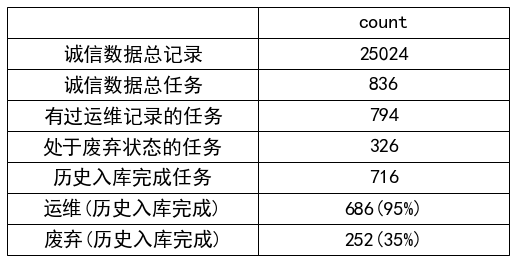

In [7]:
def draw_table(tasks_tables, tasks_tables_labels):
    text_value = np.array(tasks_tables)
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
    the_table=plt.table(cellText=text_value,colLabels=tasks_tables_labels,colWidths=[0.2]*text_value.shape[1],loc='center',cellLoc='center')
    the_table.set_fontsize(20)
    the_table.scale(2.5,2.58)
    plt.show()
tasks_tables = [
    ['%s总记录' % task_name, stat[task_name]],
    ['%s总任务' % task_name, spider_tasks_statistics[task_name]],
    ['有过运维记录的任务', operation_tasks_statistics[task_name]],
    ['处于废弃状态的任务', abandoned_tasks_statistics[task_name]],
    ['历史入库完成任务', storage_tasks_statistics[task_name]],
    ['运维(历史入库完成)', str(storage_tasks_2_statistics[task_name])+'({}%)'.format(int(storage_tasks_2_statistics[task_name]/storage_tasks_statistics[task_name]*100))],
    ['废弃(历史入库完成)', str(storage_tasks_3_statistics[task_name])+'({}%)'.format(int(storage_tasks_3_statistics[task_name]/storage_tasks_statistics[task_name]*100))],
]
tasks_tables_labels = ['', 'count']
draw_table(tasks_tables, tasks_tables_labels)

In [8]:
def get_statistics_into_template(date_template, tasks, add=True):
    _date_template = deepcopy(date_template)
    for spiderName, spider_task in tasks.items():
        if isinstance(spider_task, int):
            if spiderName in _date_template:
                _date_template[spiderName] = _date_template.get(spiderName, 0) + spider_task
            continue
        for task, value in spider_task.items():
            if task in _date_template:
                if add:
                    _date_template[task] = _date_template.get(task, 0) + value
                else:
                    _date_template[task] = _date_template.get(task, 0) + 1
    return _date_template
date_template = get_date_template(check_start_year, check_start_month)
all_into_template = get_statistics_into_template(date_template, all_tasks_3_month_statistics, add=False)
abnormal_into_template = get_statistics_into_template(date_template, abnormal_spider_tasks_statistics)
abandoned_into_template = get_statistics_into_template(date_template, abandoned_tasks_3_month_statistics)
labels = all_into_template.keys()
all_num_list = all_into_template.values()
abnormal_num_list = abnormal_into_template.values()
abandoned_num_list = abandoned_into_template.values()

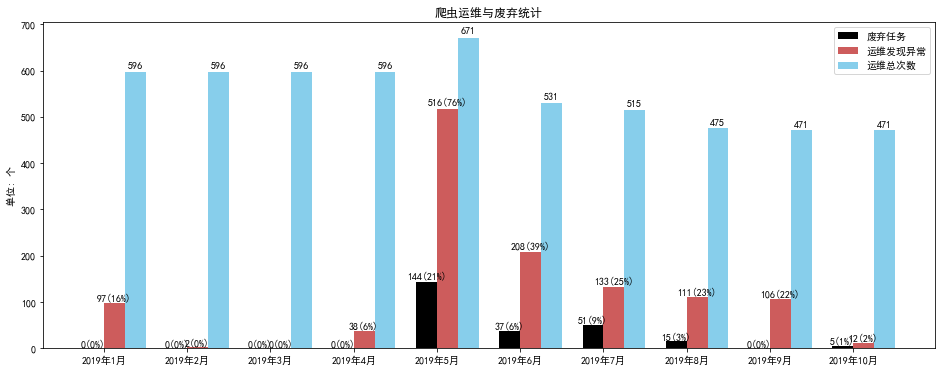

In [61]:
ind = np.arange(len(all_num_list))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, abandoned_num_list, width,
                color='black', label='废弃任务')
rects2 = ax.bar(ind + width/2, abnormal_num_list, width,
                color='IndianRed', label='运维发现异常')
rects3 = ax.bar(ind + width/2 + width, all_num_list, width,
                color='SkyBlue', label='运维总次数')
ax.set_ylabel('单位: 个')
ax.set_title('爬虫运维与废弃统计')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
def autolabel(rects, xpos='center', add_percentage=None):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for index, rect in enumerate(rects):
        height = rect.get_height()
        if add_percentage is None:
            text = '{}'.format(height)
        else:
            text = '{}({}%)'.format(height, str(int(rects1_values[add_percentage][index]*100)))
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height, text, ha=ha[xpos], va='bottom')
rects1_values = []
for rects in [rects1, rects2, rects3]:
    _rects1_values = []
    for rect in rects:
        _rects1_values.append(rect.get_height())
    rects1_values.append(np.array(_rects1_values))
rects1_values = [rects1_values[0]/rects1_values[-1], rects1_values[1]/rects1_values[-1]]
autolabel(rects1, "center", add_percentage=0)
autolabel(rects2, "center", add_percentage=1)
autolabel(rects3, "center")
fig.set_size_inches(16, 6)
plt.show()

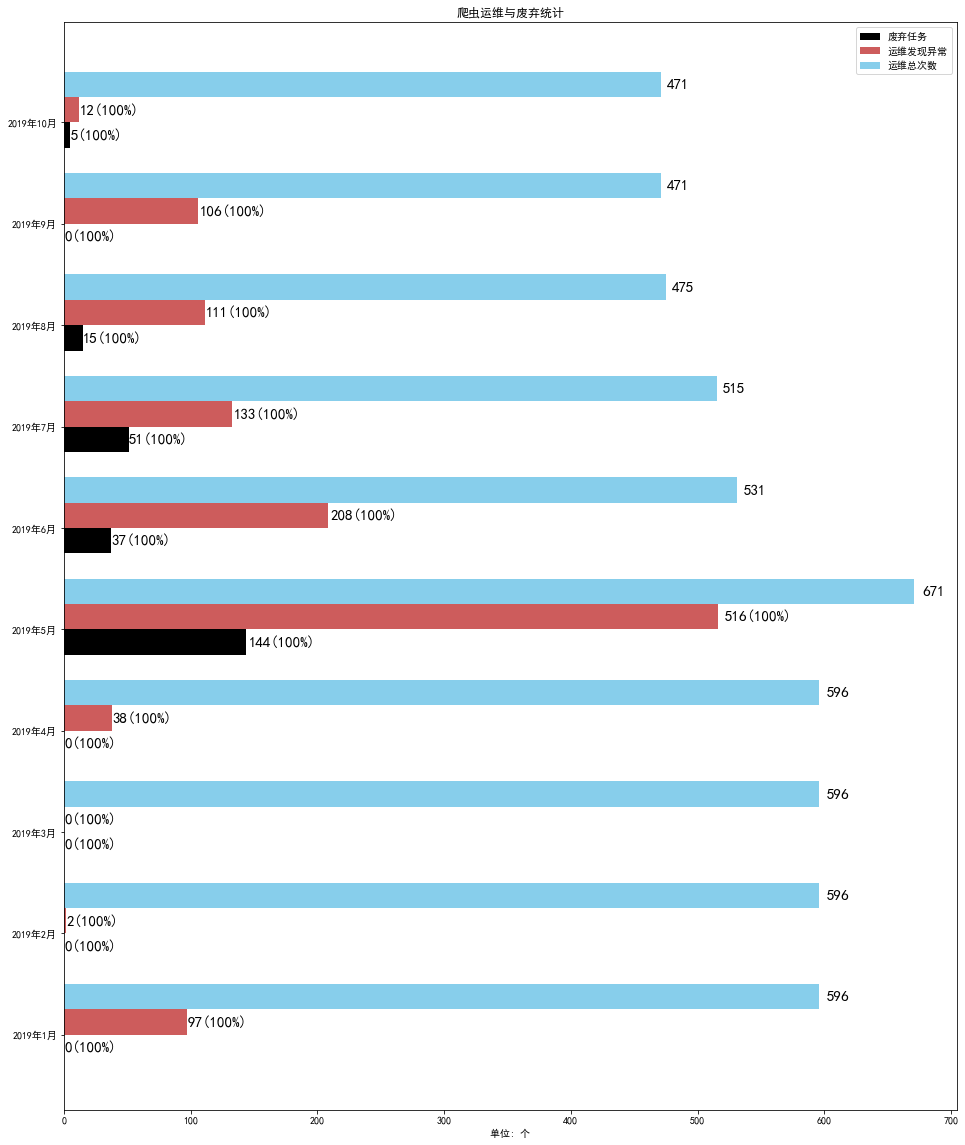

In [59]:
num_length = len(all_num_list)
ind = np.arange(num_length)
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.barh(ind - width/2, abandoned_num_list, width,
                color='black', label='废弃任务')
rects2 = ax.barh(ind + width/2, abnormal_num_list, width,
                color='IndianRed', label='运维发现异常')
rects3 = ax.barh(ind + width/2 + width, all_num_list, width,
                color='SkyBlue', label='运维总次数')
ax.set_xlabel('单位: 个')
ax.set_title('爬虫运维与废弃统计')
ax.set_yticks(ind)
ax.set_yticklabels(labels)
ax.legend()
def autolabel(rects, xpos='center', add_percentage=None):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.25}  # x_txt = x + w*off
    for index, rect in enumerate(rects):
        _width = rect.get_width()
        if add_percentage is None:
            text = '{}'.format(_width)
        else:
            text = '{}({}%)'.format(_width, str(int(rects1_values[add_percentage][index]*100)))
        ax.text(1.01 * rect.get_width(), rect.get_y() + width*offset[xpos], text, va='bottom', fontsize=15)
rects1_values = []
for rects in [rects1, rects2, rects3]:
    _rects1_values = []
    for rect in rects:
        _rects1_values.append(rect.get_height())
    rects1_values.append(np.array(_rects1_values))
rects1_values = [rects1_values[0]/rects1_values[-1], rects1_values[1]/rects1_values[-1]]
autolabel(rects1, "left", add_percentage=0)
autolabel(rects2, "left", add_percentage=1)
autolabel(rects3, "left")
fig.set_size_inches(16, num_length*2)
plt.show()